# Business Questions

# Data Understanding
In this notebook I am going to to take a look at the San Francisco AirBnB data: http://insideairbnb.com/get-the-data.html. My goal is to explore some basic trends in the types of listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [3]:
listings_df = pd.read_csv('listings.csv')

# Drop variables will all there values missing
listings_df.dropna(axis=1, how='all', inplace=True)

# Drop variables that are the same for every listing
for col in listings_df:
    if listings_df[col].value_counts().shape[0] == 1:
        listings_df.drop(columns=col, inplace=True)
        
# List all the variables
print(listings_df.shape)
set(listings_df.columns)

(8572, 95)


{'access',
 'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'extra_people',
 'first_review',
 'guests_included',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'id',
 'instant_bookable',
 'interaction',
 'is_location_exact',
 'last_review',
 'last_

In [4]:
# Drop columns not relevant for prediction
listings_df = listings_df.drop(columns=['id', 'host_id', 'host_name'])

There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [5]:
no_nulls = listings_df.columns[listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))

There are 54 columns with no missing values.


In [5]:
most_missing_cols = listings_df.columns[listings_df.isnull().mean() > 0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 3 columns with more than half of their values missing.


{'monthly_price', 'square_feet', 'weekly_price'}

In [6]:
some_missing_cols = listings_df.columns[listings_df.isnull().mean() < 0.25]

print('There are %d columns with more most of their values.' % (some_missing_cols.shape[0]))

There are 82 columns with more most of their values.


The monetary columns need to be converted from a string to a float.

In [7]:
print(listings_df['price'][0])

$170.00


In [17]:
money_cols = ['price', 'cleaning_fee', 'security_deposit']
for col in money_cols:
    listings_df[col] = listings_df[col].dropna().apply(lambda p: float(p[1:].replace(",", "")))

In [18]:
print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))
print('The average cleaning fee is $%d.' % (listings_df['cleaning_fee'].mean()))
print('The average security deposit is $%d.' % (listings_df['security_deposit'].mean()))

The average cost of a rental is $227.
The average cleaning fee is $113.
The average security deposit is $445.


Now lets do a first past to examine how much the features seem to matter in predicting price.

In [10]:
def plot_mean_price(df, col):
    
    fig, ax_array = plt.subplots(1, 2, figsize=[10,5])
    ax = ax_array.flatten()
    
    listings_df.groupby([col]).mean()['price'].sort_index().plot(kind='bar', ax=ax[0]);
    plt.title('How much does ' + col + ' matter?');
    plt.ylabel("Average Cost ($)");
    
    listings_df[col].value_counts().sort_index().plot(kind='bar', ax=ax[1]);
    plt.title('How many listings?');
    plt.ylabel("Count");

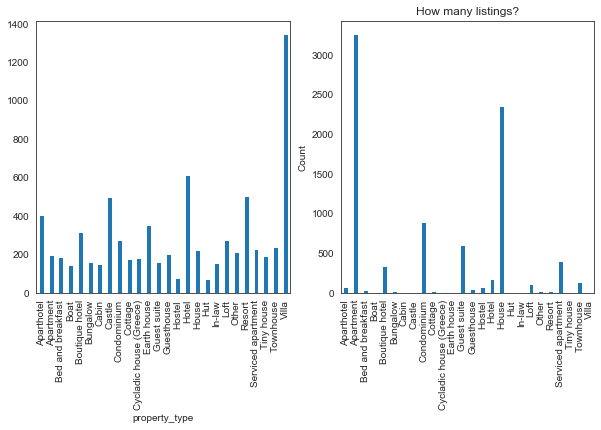

In [11]:
plot_mean_price(listings_df, 'property_type')

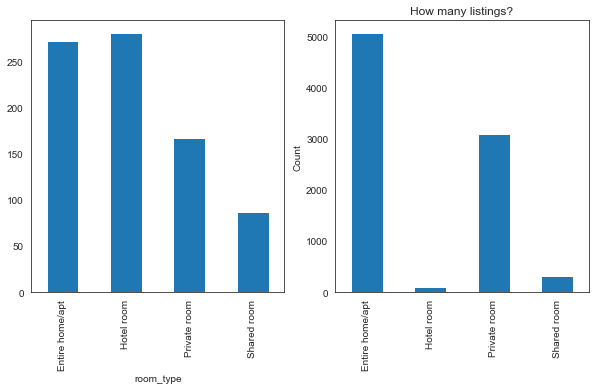

In [12]:
plot_mean_price(listings_df, 'room_type')

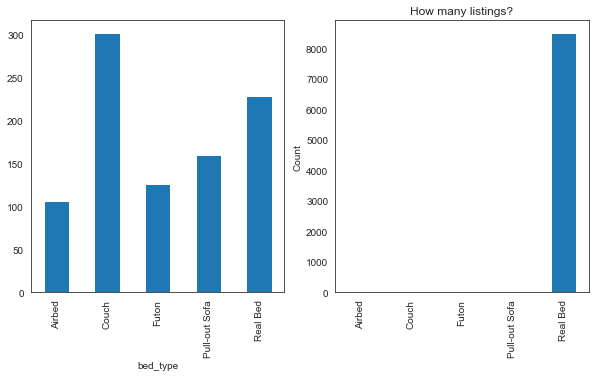

In [13]:
plot_mean_price(listings_df, 'bed_type')

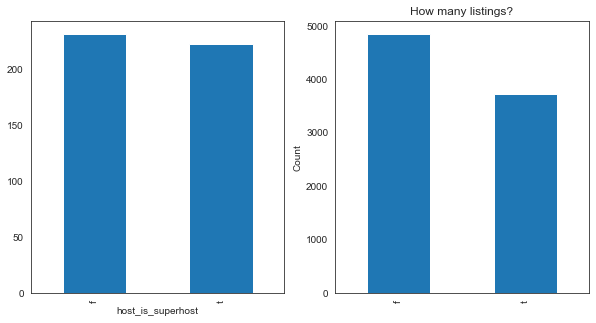

In [14]:
plot_mean_price(listings_df, 'host_is_superhost')

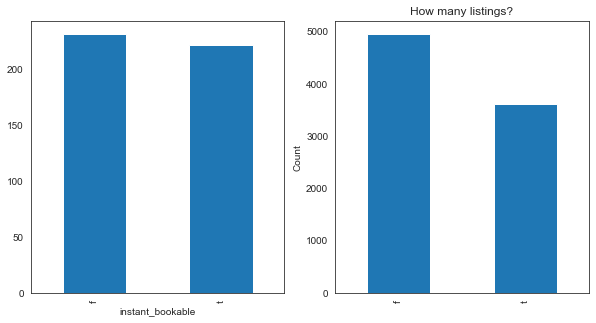

In [15]:
plot_mean_price(listings_df, 'instant_bookable')

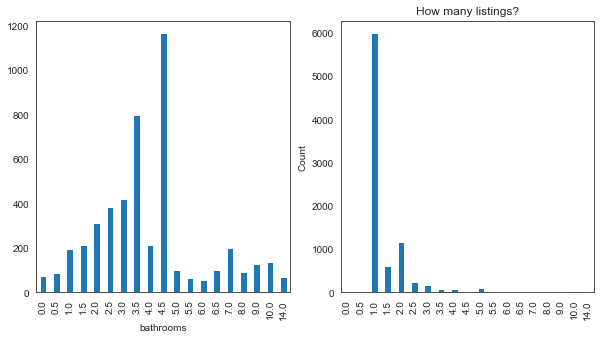

In [16]:
plot_mean_price(listings_df, 'bathrooms')

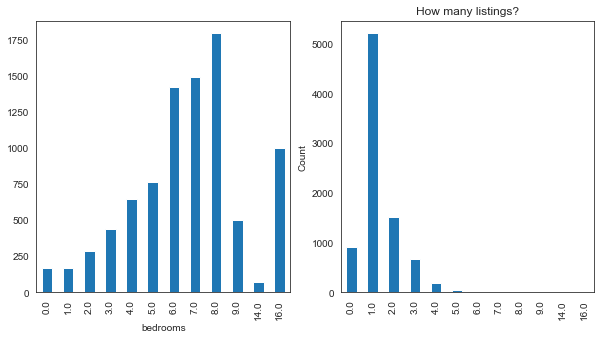

In [17]:
plot_mean_price(listings_df, 'bedrooms')

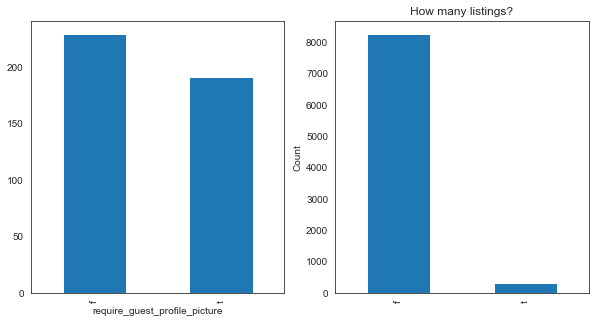

In [18]:
plot_mean_price(listings_df, 'require_guest_profile_picture')

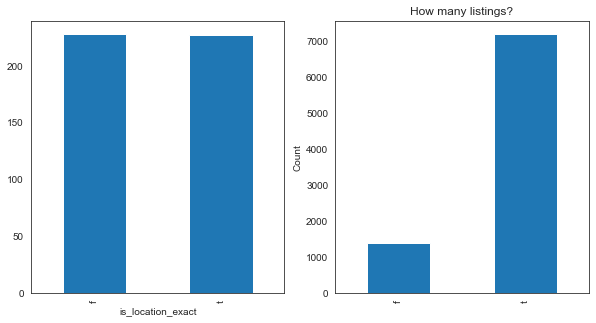

In [19]:
plot_mean_price(listings_df, 'is_location_exact')

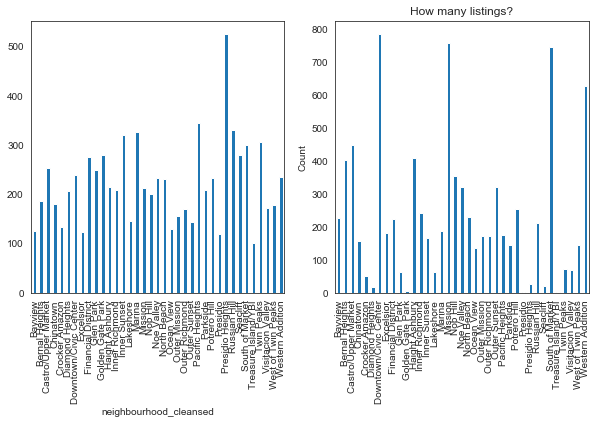

In [20]:
plot_mean_price(listings_df, 'neighbourhood_cleansed')

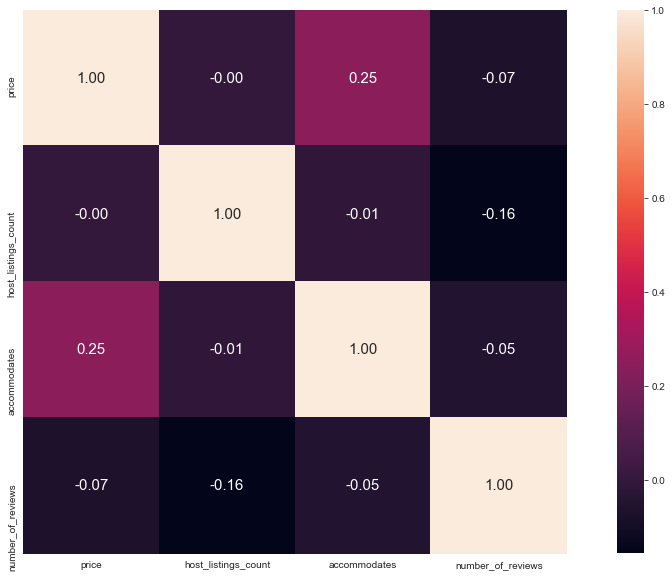

In [21]:
plt.figure(figsize=[18,10])
cols = ['price','host_listings_count', 'accommodates', 'number_of_reviews']
cm = np.corrcoef(listings_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                    yticklabels=cols, xticklabels=cols)
plt.show()

# Data Preparation

In [20]:
features = listings_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
                        'number_of_reviews', 'review_scores_rating']]
price = listings_df['price']

Next add the true/false features and change them from strings to 0 or 1.

In [21]:
tf_cols = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','instant_bookable',
           'require_guest_profile_picture', 'require_guest_phone_verification']
for col in tf_cols:
    new_feature = listings_df[col].map(lambda s: 0 if s == "f" else 1)
    features.insert(column=col, value=new_feature, loc=0) 

Next I will convert categorical features to dummy features

In [22]:
cat_col = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']
for col in cat_col:
    features = pd.concat([features, pd.get_dummies(listings_df[col], prefix=col[0:5], prefix_sep='_', 
                                                   drop_first=True, dummy_na=True)], axis=1)

In [23]:
# Many features have missing values, but only 1 has the majority missing.
print(features.columns[features.isnull().mean() > 0].shape[0])
print(features.columns[features.isnull().mean() > 0.5])

4
Index([], dtype='object')


So as to not waste this data I will impute the mean.

In [24]:
fill_mean = lambda col: col.fillna(col.mean()) 
features = features.apply(fill_mean, axis=0) 

In [25]:
# Now there are no missing values.
print(features.columns[features.isnull().mean() > 0].shape[0])

0


In [26]:
features.shape

(8572, 85)

In [27]:
# remove ultra-high price listings from modeling
y = price[price < 600]
X = features[price < 600]
X.shape

(8196, 85)

## Modeling

In [32]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

This model does horrible and is greatly overfitting the data.

In [33]:
reg = LinearRegression().fit(X_train, y_train)

In [34]:
reg.score(X_test, y_test)

0.5316788199990402

In [35]:
print(mean_squared_error(reg.predict(X_train), y_train)**0.5)
print(mean_squared_error(reg.predict(X_test), y_test)**0.5)

74.01891421315054
74.16891011480416


In [36]:
print("Start with $%d" % reg.intercept_)
for i, c in enumerate(reg.coef_):
    if c > 1 or c < -1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-73
$18.035258 for accommodates
$32.593932 for bedrooms
$-4.133366 for beds
$7.006944 for guests_included
$1.203579 for review_scores_rating
$8.917338 for host_is_superhost
$7.355552 for host_identity_verified
$4.183499 for host_has_profile_pic
$-5.300205 for instant_bookable
$-22.687107 for require_guest_profile_picture
$4.075539 for require_guest_phone_verification
$30.968698 for neigh_Bernal Heights
$67.375011 for neigh_Castro/Upper Market
$74.802374 for neigh_Chinatown
$3.949132 for neigh_Crocker Amazon
$25.781571 for neigh_Diamond Heights
$51.184806 for neigh_Downtown/Civic Center
$-4.596119 for neigh_Excelsior
$82.214809 for neigh_Financial District
$47.953301 for neigh_Glen Park
$66.466054 for neigh_Golden Gate Park
$55.945132 for neigh_Haight Ashbury
$55.443712 for neigh_Inner Richmond
$42.015677 for neigh_Inner Sunset
$13.459160 for neigh_Lakeshore
$83.524889 for neigh_Marina
$56.379221 for neigh_Mission
$55.975191 for neigh_Nob Hill
$63.506248 for neigh_Noe Valley

In [48]:
las = Lasso(alpha = 1, max_iter=1000).fit(X_train, y_train)

In [49]:
print(mean_squared_error(las.predict(X_train), y_train)**0.5)
print(mean_squared_error(las.predict(X_test), y_test)**0.5)

78.46369587468969
77.69849131936412


In [50]:
print("Start with $%d" % las.intercept_)
for i, c in enumerate(las.coef_):
    if c > 1 or c < -1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-43
$20.541860 for accommodates
$28.347235 for bedrooms
$-2.567854 for beds
$4.922220 for guests_included
$1.503154 for review_scores_rating
$4.422684 for host_is_superhost
$6.718570 for host_identity_verified
$-1.753325 for instant_bookable
$-4.566579 for neigh_Excelsior
$-7.139237 for neigh_Outer Sunset
$3.573722 for neigh_Potrero Hill
$10.019615 for neigh_South of Market
$-11.981319 for prope_Apartment
$14.283092 for prope_Boutique hotel
$8.402894 for prope_Condominium
$-16.753365 for prope_Guest suite
$-16.585995 for prope_House
$-39.814703 for room__Private room
$-74.558264 for room__Shared room


Now I want to add a feature that takes into account longitude and latitude. However this data is not linearly separable so a linear regression might struggle.

In [245]:
knn_features = listings_df[['longitude', 'latitude','bedrooms','accommodates']][price < 600]

knn_features = knn_features.apply(fill_mean, axis=0) 

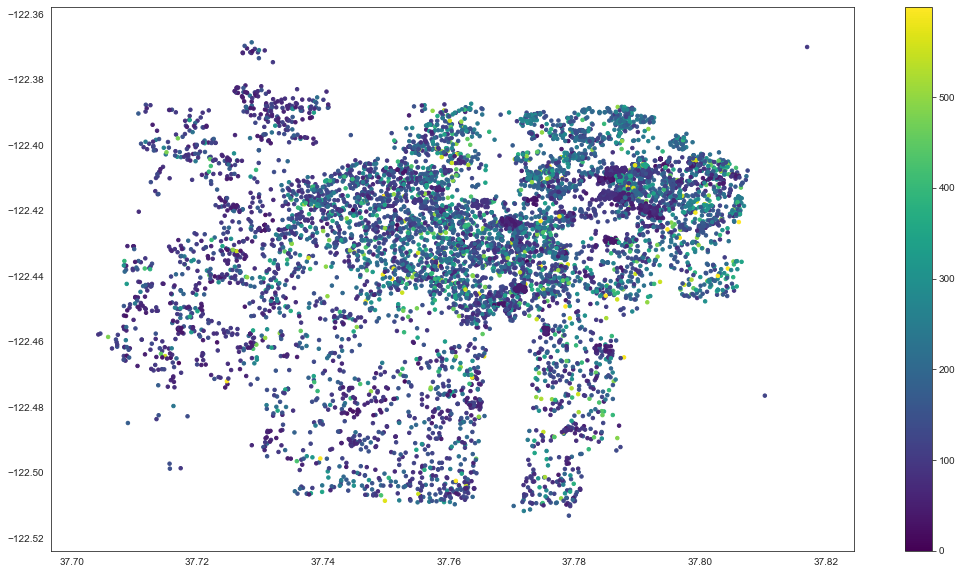

In [246]:
plt.figure(figsize=[18,10])
plt.scatter(knn_features['latitude'], knn_features['longitude'],
            c=y, cmap='viridis',s=12)
cbar = plt.colorbar()

In [247]:
# Split data into training and test data, and fit a linear model
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(knn_features, y, test_size=.30, random_state=42)

In [248]:
neigh = KNeighborsRegressor(n_neighbors=10).fit(X_knn_train, y_train)

In [249]:
print(mean_squared_error(neigh.predict(X_knn_train), y_train)**0.5)
print(mean_squared_error(neigh.predict(X_knn_test), y_test)**0.5)

69.68156981113377
75.50677467322701


In [250]:
X_train['knn'] = neigh.predict(X_knn_train)
X_test['knn'] = neigh.predict(X_knn_test)

/Users/andrewblaikie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/andrewblaikie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [251]:
reg2 = Lasso(alpha=1).fit(X_train, y_train)

In [252]:
print(mean_squared_error(reg2.predict(X_train), y_train)**0.5)
print(mean_squared_error(reg2.predict(X_test), y_test)**0.5)

68.27212489763409
73.74336845660379


In [253]:
print("Start with $%d" % reg2.intercept_)
for i, c in enumerate(reg2.coef_):
    if c > 0.1 or c < -0.1:
        print("$%f for %s" % (c, X_train.columns[i]))

Start with $-74
$-0.725112 for accommodates
$-3.409085 for beds
$5.071686 for guests_included
$0.954159 for review_scores_rating
$1.317174 for host_identity_verified
$-1.354022 for instant_bookable
$-3.777193 for prope_Apartment
$3.877700 for prope_Condominium
$-12.172055 for room__Private room
$-5.203445 for room__Shared room
$0.945553 for knn


Can a nonlinear regressor do better? Yes, they have lower mean squared errors on the test set, but are more clearly overfitting.

In [254]:
forest = RandomForestRegressor(n_estimators=200).fit(X_train, y_train)

In [255]:
print(mean_squared_error(forest.predict(X_train), y_train)**0.5)
print(mean_squared_error(forest.predict(X_test), y_test)**0.5)

25.17968894854203
69.79417454193253


In [256]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(10):
    print("The number %d most important feature is %s" % (i+1, X_train.columns[indices[i]]))

The number 1 most important feature is knn
The number 2 most important feature is number_of_reviews
The number 3 most important feature is review_scores_rating
The number 4 most important feature is bathrooms
The number 5 most important feature is guests_included
The number 6 most important feature is accommodates
The number 7 most important feature is beds
The number 8 most important feature is room__Private room
The number 9 most important feature is bedrooms
The number 10 most important feature is host_identity_verified


In [154]:
mlp = MLPRegressor(activation='relu',max_iter=2000, hidden_layer_sizes=(10,5)).fit(X_train, y_train)

In [155]:
mlp.score(X_test, y_test)

0.5675501893095126

In [156]:
print(mean_squared_error(mlp.predict(X_train), y_train)**0.5)
print(mean_squared_error(mlp.predict(X_test), y_test)**0.5)

68.01745988179319
71.27182068013748


# Summary